In [1]:
what_were_covering = {1: "data(preapere and load)",
                      2: "build model",
                      3: "fitting the model to data (training)",
                      4: "making predictions and evaluating a model",
                      5: "saving and loading a model",
                      6: "putting it all together"}


what_were_covering

{1: 'data(preapere and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model',
 5: 'saving and loading a model',
 6: 'putting it all together'}

In [2]:
import torch
from torch import nn ## nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.4.0+cu121'

## 1-Data ( Preparing and Loading)

Data can be almost anything.. in machine learning

* Excel spreadsheets
* Videos
* Images of any kind
* Audio
* DNA
* Text

ML is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation

To showcase this, let's create some **known** data using the linear regression formula

We'll use a linear regression formula to make a straight line with known **parameters**.

In [3]:
# Create known parameters

weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1

step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

### Splitting data into training and test sets

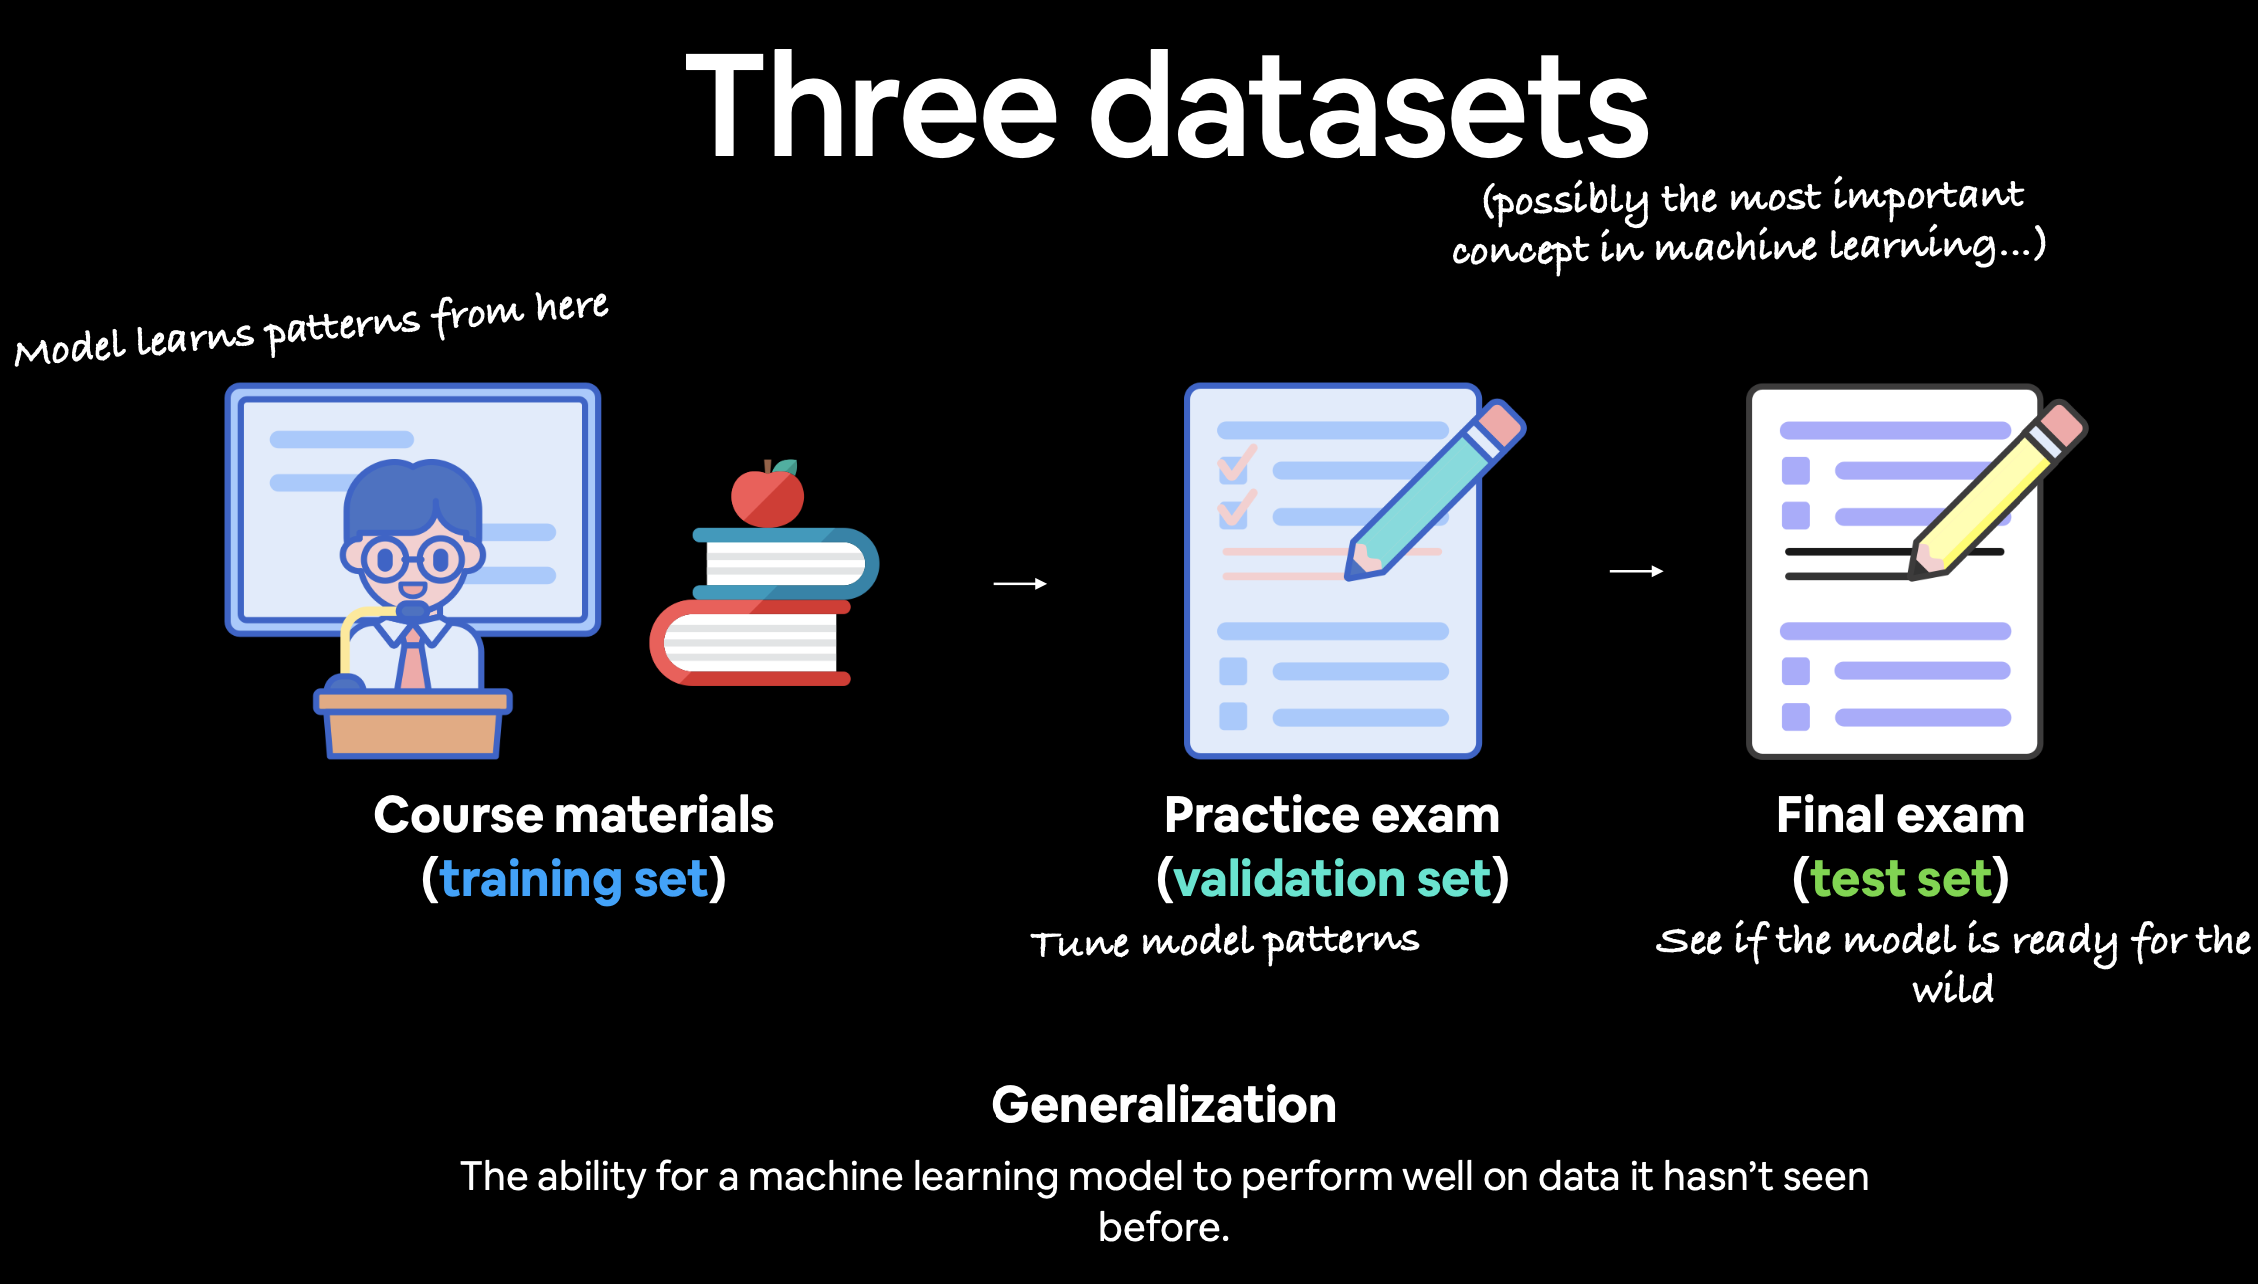

In [4]:
# Create a train/test split

train_split = int(0.8* len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

How might we better visualize our data?

This is where the data explorer's motto comes in!

"Visualize Visualize Visualize!"

In [5]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
  """
  Plots training data, test data and compares predictions.
  """

  plt.figure(figsize=(10,7))
  # Plot training data blue
  plt.scatter(train_data, train_labels, c='b', s=4, label='Training data')
  # Plot test data green
  plt.scatter(test_data, test_labels, c='g', s=4, label='Test data')
  if predictions is not None:
    # Plot predictions in red
    plt.scatter(test_data, predictions, c='r', s=4, label = 'Predictions')
  #Show the legend
  plt.legend(prop={"size":14});

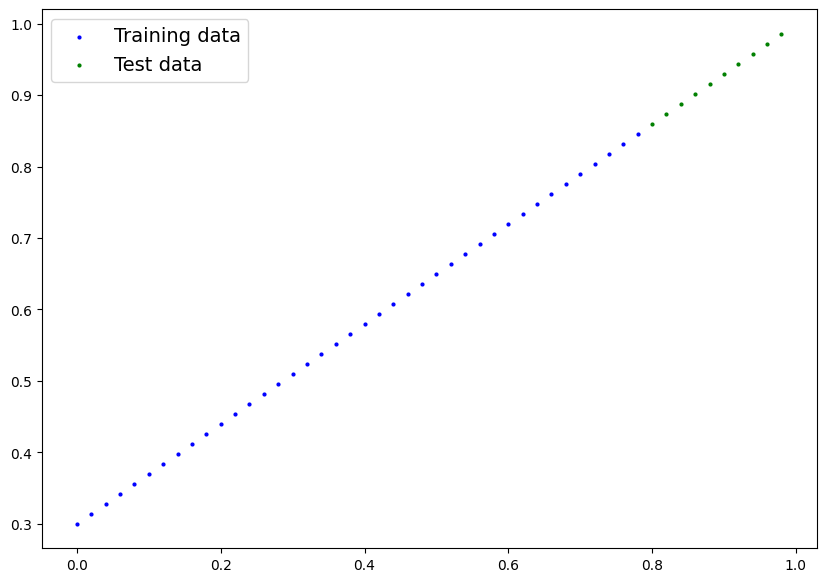

In [6]:
plot_predictions();

## 2. Build Model

Our first PyTorch model

[Python Classes](https://realpython.com/python-classes/)

What our model does:

* start with random values (w & b)
* look at training data and adjust the random values to better represent the ideal values

How does it do so?

Through two main algorithms:
1. Gradient Descent
2. Backpropagation

In [7]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

###  Pytorch model building essentials

* torch.nn - contains all of the buildings for computitional graphs (NN can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a Pytorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizers in Pytorch live, they will help with gradient descent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happened in the forward computation

### Checking the contents of our Pytorch Model

Now we've created a model, let's see what's inside

So we can check our model parameters or what's inside our model usin `.parameters()`

In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters

list(model_0.parameters())


[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters

model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
weight, bias

(0.7, 0.3)

### Making predictions using `torch.inference_mode()`

To check out our model's predictive power, let's see how well it predicts `y_test` based on `X_test`

When we pass our data through our model, it's going to run it through the `forward()` method.



In [11]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

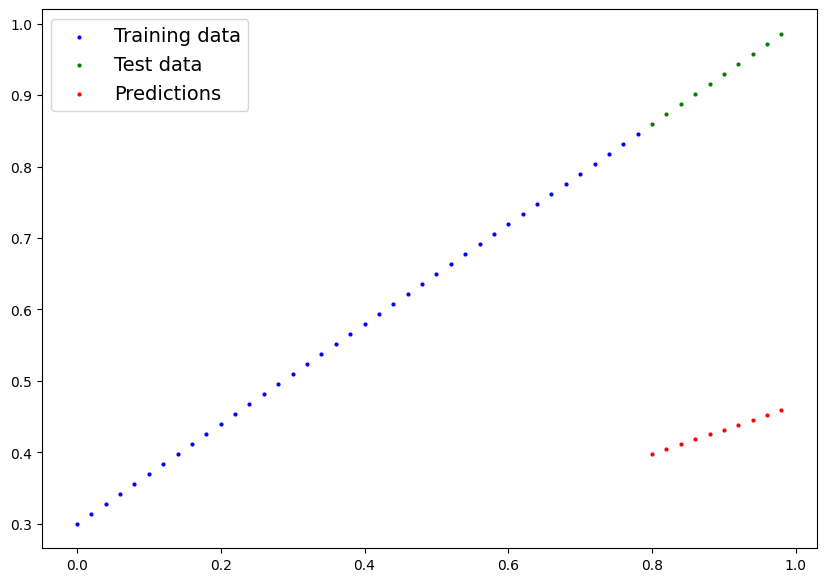

In [12]:
plot_predictions(predictions=y_preds)

### 3. Train model

The whole idea of training is for a model to move from some unknown parameters (these may be random) to some **known** parameters.

Or in other words from a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use lose functions

Things we need to train:

* **Loss Function:** A function to measure how wrong your model's predictions are the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjust the model's parameters (e.g. weight & bias) to improve the loss function.

And specifically for PyTorch we need:
* Traning loop
* Testing loop


In [13]:
# Check our parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
# Setup a loss function

loss_fn = nn.L1Loss() #MAE

# Setup an optimizer

optimizer = torch.optim.SGD(params =model_0.parameters(), lr= 0.01)

### Building a Training/Testing Loop in PyTorch

Things we need in a training loop:

0. Loop through the data
1. Forward pass (this involves data moving through our model's `forward()`) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground thruth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagation**)
5. Optimizer step - use the optimizer adjust our model's parameters to try and improve the loss (**gradient descent**)



In [15]:
# An epoch is one loop through the data (hyperparameter)
epochs = 100

## Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() # train mode in Pytorch sets all parameters that require gradients to require gradient

  # 1. Forward pass
  y_pred = model_0(X_train)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train) # How wrong model predictions are
  print(f"Loss: {loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad() #they accumulate every epoch, zero them to start fresh each forward pass

  #4. Perform backpropagation
  loss.backward()

  #5. Step the optimizer
  optimizer.step()

  model_0.eval() # turns off gradient tracking

  #Print our model state_dict()
  print(model_0.state_dict())

Loss: 0.31288138031959534
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Loss: 0.3013603389263153
OrderedDict([('weights', tensor([0.3445])), ('bias', tensor([0.1488]))])
Loss: 0.28983935713768005
OrderedDict([('weights', tensor([0.3484])), ('bias', tensor([0.1588]))])
Loss: 0.2783183455467224
OrderedDict([('weights', tensor([0.3523])), ('bias', tensor([0.1688]))])
Loss: 0.26679736375808716
OrderedDict([('weights', tensor([0.3562])), ('bias', tensor([0.1788]))])
Loss: 0.2552763521671295
OrderedDict([('weights', tensor([0.3601])), ('bias', tensor([0.1888]))])
Loss: 0.24375534057617188
OrderedDict([('weights', tensor([0.3640])), ('bias', tensor([0.1988]))])
Loss: 0.23223432898521423
OrderedDict([('weights', tensor([0.3679])), ('bias', tensor([0.2088]))])
Loss: 0.22071333229541779
OrderedDict([('weights', tensor([0.3718])), ('bias', tensor([0.2188]))])
Loss: 0.20919232070446014
OrderedDict([('weights', tensor([0.3757])), ('bias', tensor([0.2288]))])
Loss: 0.19767

In [16]:
# No run
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [17]:
# run with several epochs
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [18]:
weight, bias

(0.7, 0.3)

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

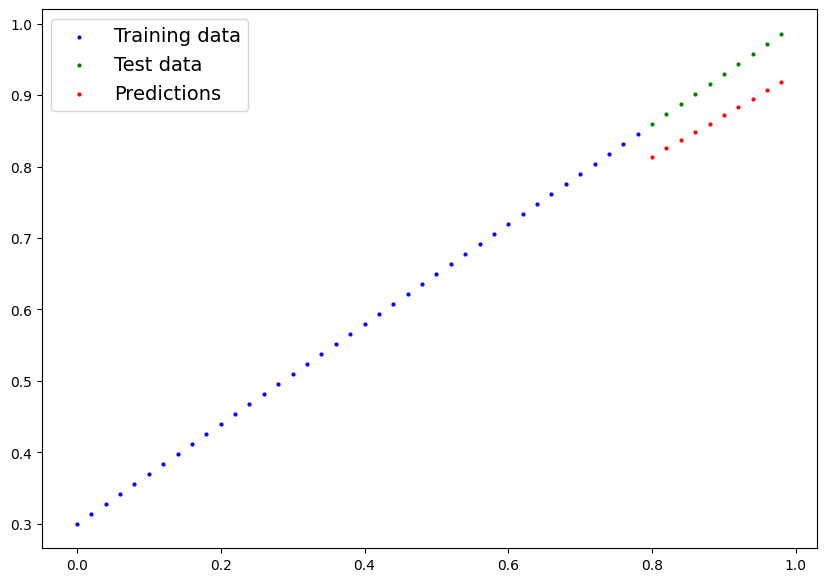

In [20]:
plot_predictions(predictions=y_preds_new)